### *Importing necessary libraries for data manipulation, preprocessing, visualization, and machine learning.*

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay
)

### *Loading and Preprocessing the Dataset*
#### *- Loading the dataset and separating features (X) and target variable (y).*


In [2]:
# Load and preprocess the dataset
file_path = 'weather_final.csv'   
data = pd.read_csv(file_path)
X = data.drop(columns=['RainTomorrow'])
y = data['RainTomorrow']

### *Handle Missing Values and Standardize Features*
#### *- Imputing missing values using mean strategy.*
#### *- Standardizing features to ensure consistent scaling.*
#### *- Adjusting data for MultinomialNB (non-negative features).*


In [3]:
# Handle missing values and standardize
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# For MultinomialNB, ensure non-negative features
X_train_multinomial = X_train - X_train.min()
X_test_multinomial = X_test - X_test.min()

### *Train Multiple Models*
#### *1. MultinomialNB: Performing hyperparameter tuning using GridSearchCV.*
#### *2. GaussianNB: Training and evaluating the model.*
#### *3. BernoulliNB: Performing hyperparameter tuning using GridSearchCV.*


In [4]:
# Train all models
# 1. MultinomialNB
mnb_model = MultinomialNB()
mnb_params = {'alpha': [0.1, 0.5, 1.0, 2.0]}
grid_search_mnb = GridSearchCV(mnb_model, mnb_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_mnb.fit(X_train_multinomial, y_train)
mnb_pred = grid_search_mnb.predict(X_test_multinomial)
mnb_accuracy = accuracy_score(y_test, mnb_pred)

# 2. GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)
gnb_accuracy = accuracy_score(y_test, gnb_pred)

# 3. BernoulliNB
bnb_model = BernoulliNB()
bnb_params = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'binarize': [0.0, 0.5, 1.0]
}
grid_search_bnb = GridSearchCV(bnb_model, bnb_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_bnb.fit(X_train, y_train)
bnb_pred = grid_search_bnb.predict(X_test)
bnb_accuracy = accuracy_score(y_test, bnb_pred)

### Select the Best Model
#### *- Comparing accuracy scores of MultinomialNB, GaussianNB, and BernoulliNB.*
#### *- Identifing the best model and use it for further evaluation.*


In [5]:
# Find best model
accuracies = {
    'MultinomialNB': (mnb_accuracy, grid_search_mnb, X_test_multinomial),
    'GaussianNB': (gnb_accuracy, gnb_model, X_test),
    'BernoulliNB': (bnb_accuracy, grid_search_bnb, X_test)
}

best_model_name = max(accuracies.items(), key=lambda x: x[1][0])[0]
best_accuracy, best_model, X_test_best = accuracies[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")


Best Model: GaussianNB
Best Accuracy: 0.7385


### *Evaluate the Best Model*
#### *- Making predictions and calculate probabilities.*
#### *- Generating a classification report.*

In [6]:
# Get predictions from best model
y_pred = best_model.predict(X_test_best)
y_pred_proba = best_model.predict_proba(X_test_best)[:, 1]

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.75     27211
           1       0.76      0.70      0.73     27444

    accuracy                           0.74     54655
   macro avg       0.74      0.74      0.74     54655
weighted avg       0.74      0.74      0.74     54655



#### *- Visualize the confusion matrix*

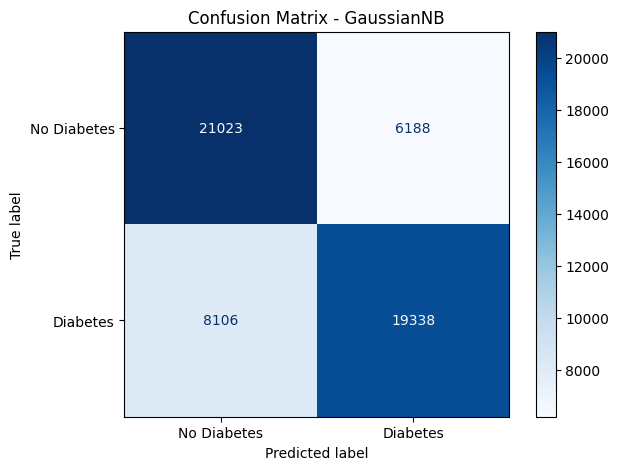

In [10]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
fig, ax1 = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Diabetes', 'Diabetes']).plot(ax=ax1, cmap='Blues')
ax1.set_title(f'Confusion Matrix - {best_model_name}')
plt.show()

 #### *-Computing the ROC curve and AUC score and visualizing it*

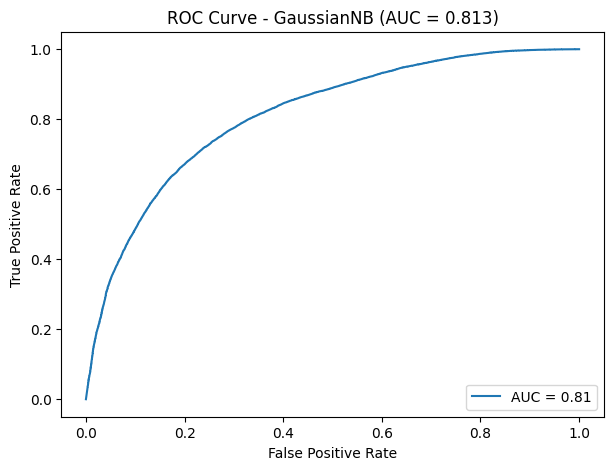

In [11]:
# Calculate ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)

# Plot ROC Curve
fig, ax2 = plt.subplots(figsize=(7, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score).plot(ax=ax2)
ax2.set_title(f'ROC Curve - {best_model_name} (AUC = {auc_score:.3f})')
plt.show()